In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import matplotlib as mpl
    
import sys  
sys.path.insert(0, '../src/')

from astropy.table import Table

import galhalo
from jsm_massfunc import CSMF, H2H_CSMF, cumulative
from jsm_datareduc import prep_data
import os

In [73]:
Ms = prep_data("../../data/12_4_0/numpy/acc_surv_mass.npy")

In [81]:
Ms.shape

(3129, 341)

In [82]:
Nreal = np.array([Ms.shape[0],2000,1000,500,300,100,50,5])

mat = np.zeros(shape=(Nreal.shape[0], 3, 50))

mass_range = np.log10(np.logspace(3,10,50))

In [83]:
for i,N in enumerate(Nreal):

    choice = np.random.choice(Ms.shape[0], size=N, replace=False)

    CSMF_i = CSMF(Ms[choice], mass_range) # accreation mass of the surviving halos!
    
    mat[i] = CSMF_i 

In [84]:
colors = ["blue", "orange", "green", "red", "purple", "brown", "pink", "cyan"]

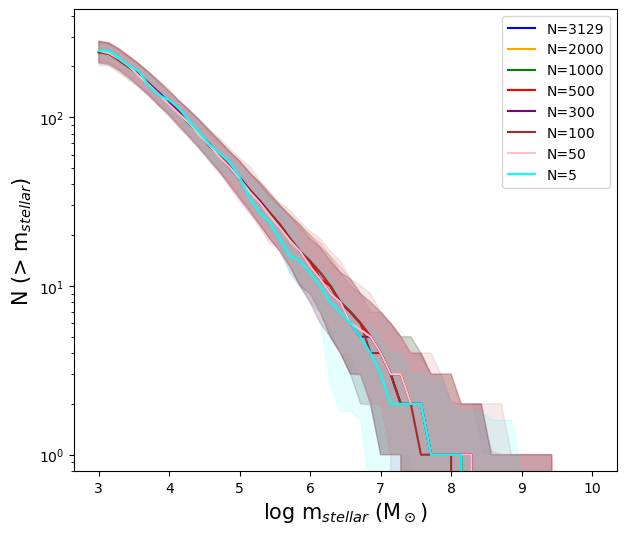

In [85]:
plt.figure(figsize=(7,6))

for i,val in enumerate(mat):
    
    plt.plot(mass_range, val[1,:], color=colors[i], label="N="+str(Nreal[i]))
    plt.fill_between(mass_range, y1=val[0, :], y2=val[2, :], alpha=0.1, color=colors[i])

plt.yscale("log")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("N (> m$_{stellar}$)", fontsize=15)
plt.legend()
plt.ylim(0.8)
plt.show()

In [86]:
det_CSMF = CSMF(Ms, mass_bins=mass_range)

det_stat = det_CSMF[2] - det_CSMF[0]

In [87]:
stat = H2H_CSMF(mat)

mass_ind = [8,15,22,29,35]
masses = np.round(mass_range[mass_ind],0)
colors = ["maroon", "red", "orange", "green", "navy"]

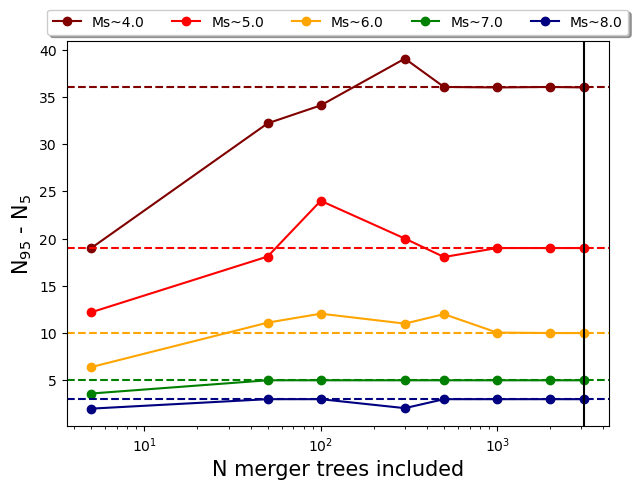

In [91]:
plt.figure(figsize=(7,5))

for i,val in enumerate(mass_ind):
    plt.plot(Nreal, stat[:,val], label="Ms~"+str(masses[i]), color=colors[i],marker="o")
    plt.axhline(det_stat[val], ls="--", color=colors[i])

 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=5, fancybox=True, shadow=True)
plt.axvline(3129, color="black")
plt.xlabel("N merger trees included", fontsize=15)
plt.ylabel("$\mathrm{N}_{95}$ - $\mathrm{N}_{5}$", fontsize=15)
plt.xscale("log")
plt.savefig("../../figures/CSMF_Nreal.png")
plt.show()

In [34]:
### now lets see what happens with a single realization, sampled N different times

In [35]:
Ms = prep_data("../../data/12_4_0/numpy/acc_surv_mass.npy")[45]

In [36]:
N_samptype = 5
sigma = 0.5
max_samp_size = 100000

In [37]:
mat = np.full((N_samptype, Ms.shape[0], max_samp_size), np.nan)

In [38]:
for i, val in enumerate(range(1,6)):
    for j, subhalo in enumerate(Ms):
        samp = np.random.normal(loc=subhalo, scale=sigma, size=10**val)
        if 10**val == max_samp_size:
            mat[i,j] = samp
        else:
            mat[i, j] = np.pad(samp, (0,max_samp_size-len(samp)), constant_values=np.nan)

In [39]:
new_mat = np.zeros(shape=(N_samptype, max_samp_size, 50))

for i in range(N_samptype):
    for j in range(max_samp_size):
        count = cumulative(mat[i,:,j], mass_range)
        if count[0] == 0:
            new_mat[i,j] = np.full(50,np.nan)
        else:
            new_mat[i,j] = count

In [40]:
np.sum(np.isnan(new_mat[4]))

0

In [41]:
test = np.nanmean(new_mat,axis=1)

In [42]:
colors = ["maroon", "red", "orange", "green", "navy"]

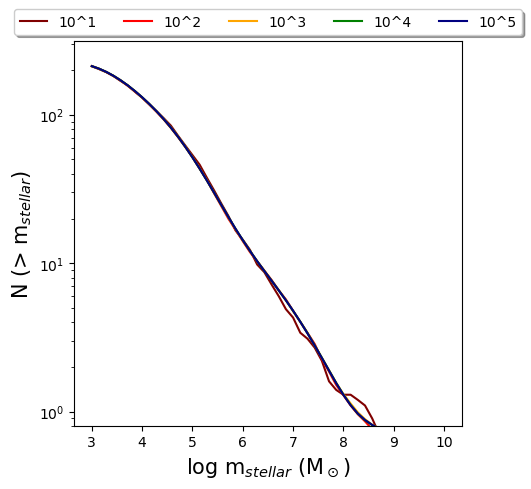

In [48]:
plt.figure(figsize=(5,5))

for i in range(5):
    plt.plot(mass_range, test[i], color=colors[i], label="10^"+str(i+1))

plt.yscale("log")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("N (> m$_{stellar}$)", fontsize=15)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=5, fancybox=True, shadow=True)
plt.ylim(0.8)
plt.savefig("../figures/gauss_sampsize_CSMF.png")
plt.show()

In [44]:
mass_ind = [8,15,22,29,35]
masses = np.round(mass_range[mass_ind],0)
samps = np.log10(np.array([10,100,1000,10000,100000]))

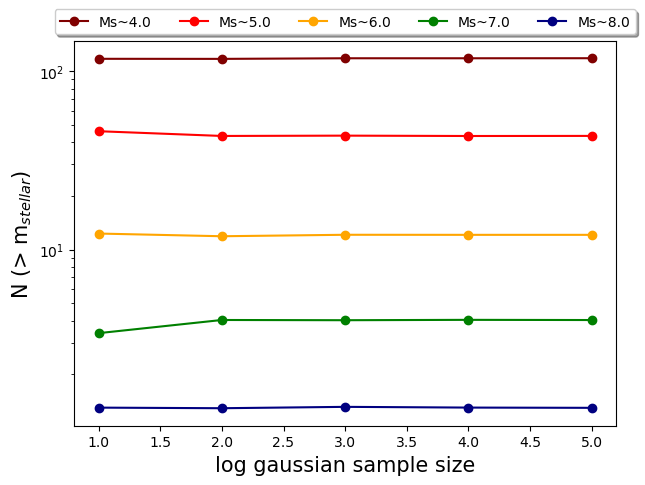

In [51]:
plt.figure(figsize=(7,5))

for i,val in enumerate(mass_ind):
    plt.plot(samps, test[:,val], label="Ms~"+str(masses[i]), color=colors[i], marker="o")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=5, fancybox=True, shadow=True)
plt.xlabel("log gaussian sample size", fontsize=15)
plt.ylabel("N (> m$_{stellar}$)", fontsize=15)
plt.yscale("log")
plt.savefig("../figures/gauss_sampsize.png")
plt.show()